## 1. Introduction

### Does the Host country have an advantage when it comes to winning medals in the olympics?

![Olympic Logo](Olympic.png)

To answer this question we will use the [Guardian Olympic medal dataset](https://www.theguardian.com/sport/datablog/2012/jun/25/olympic-medal-winner-list-data). The data is also available offline as an Excel sheet [here](data/Summer_Olympics.xlsx).

We start with loading only the relevant data i.e. medals won, list of venues etc. Then we aggregate the medal ata to count the medals won by every country in every event, applying a fraction over the total and then an expanding mean provides the percentage change from the last instance. We join this data over with the list of hosts to see if the change in win rate is significant.

## 2a. Preparation

In [1]:
%pylab notebook
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## 2b. Load the datasets
We restrict columns as we only need a subset of them.

In [2]:
medalists = pd.read_csv('data/medalists.csv', header=0, index_col='Edition', usecols=['Athlete', 'NOC', 'Medal', 'Edition'])
editions = pd.read_csv('data/editions.tsv',sep='\t',header=0, usecols=['Edition', 'Grand Total', 'City', 'Country']
)
ioc_codes = pd.read_csv('data/ioc_codes.csv', header=0, usecols=['Country', 'NOC'])

Also we will create the hosts dataframe by merging editions with ioc_codes.

In [3]:
hosts = pd.merge(editions, ioc_codes, how='left')
hosts = hosts[['Edition', 'NOC']].set_index('Edition')

There is a bit of missing data here so we fix it.

In [4]:
#print(hosts.loc[hosts.NOC.isnull()])
hosts.loc[1972, 'NOC'] = 'FRG'
hosts.loc[1980, 'NOC'] = 'URS'
hosts.loc[1988, 'NOC'] = 'KOR'
hosts = hosts.reset_index()

 ## 2c. Previews

In [5]:
medalists.head(10)

,Athlete,NOC,Medal
Edition,,,
1896,"HAJOS, Alfred",HUN,Gold
1896,"HERSCHMANN, Otto",AUT,Silver
1896,"DRIVAS, Dimitrios",GRE,Bronze
1896,"MALOKINIS, Ioannis",GRE,Gold
1896,"CHASAPIS, Spiridon",GRE,Silver
1896,"CHOROPHAS, Efstathios",GRE,Bronze
1896,"HAJOS, Alfred",HUN,Gold
1896,"ANDREOU, Joannis",GRE,Silver
1896,"CHOROPHAS, Efstathios",GRE,Bronze


In [6]:
editions.head(10)

,Edition,Grand Total,City,Country
0,1896,151,Athens,Greece
1,1900,512,Paris,France
2,1904,470,St. Louis,United States
3,1908,804,London,United Kingdom
4,1912,885,Stockholm,Sweden
5,1920,1298,Antwerp,Belgium
6,1924,884,Paris,France
7,1928,710,Amsterdam,Netherlands
8,1932,615,Los Angeles,United States
9,1936,875,Berlin,Germany


In [7]:
hosts.head()

,Edition,NOC
0,1896,GRE
1,1900,FRA
2,1904,USA
3,1908,GBR
4,1912,SWE


## 3. Aggregate the data
Here we will prepare a list of number of medals won be every country every year. For this we pivot the medals information with Edition as the index, Athelete as the values and NOC for the columns

In [8]:
medal_counts = medalists.pivot_table(index='Edition',values='Athlete', columns='NOC', aggfunc='count')

Every year also has the total number of medals in the edition dataframe, in the Grand total column. From this we can calculate the fraction values over the medal_counts dataframe.

In [9]:
totals = editions.set_index('Edition')
totals = totals['Grand Total']
fractions = medal_counts.divide(totals, axis='rows')

To see if there is a host country advantage, we first want to see how the fraction of medals won changes from edition to edition. The expanding mean provides a way to see this down each column.



In [10]:
mean_fractions = fractions.expanding().mean()
fractions_change = mean_fractions.pct_change() * 100
fractions_change = fractions_change.reset_index()

## 4. Reshaping for analysis
We will reshape fractions_change via melting over the identifier Edition so that we can summarize the fractional change in the expanding mean of the percentage of medals won for each country in blocks. Then we merged this reshaped data with hosts info as an inner join to correlate the change in medal winning for every time the given country was the host. 

In [11]:
reshaped = pd.melt(fractions_change, id_vars='Edition', value_name='Change')
merged = pd.merge(reshaped, hosts, how='inner')
influence = merged.set_index('Edition').sort_index()
influence.head()

,NOC,Change
Edition,,
1896,GRE,NaN
1900,FRA,198.002486
1904,USA,199.651245
1908,GBR,134.489218
1912,SWE,71.896226


## 5. Plotting the influence
We will plot the Change column vs the Cities being the Host.

<IPython.core.display.Javascript object>


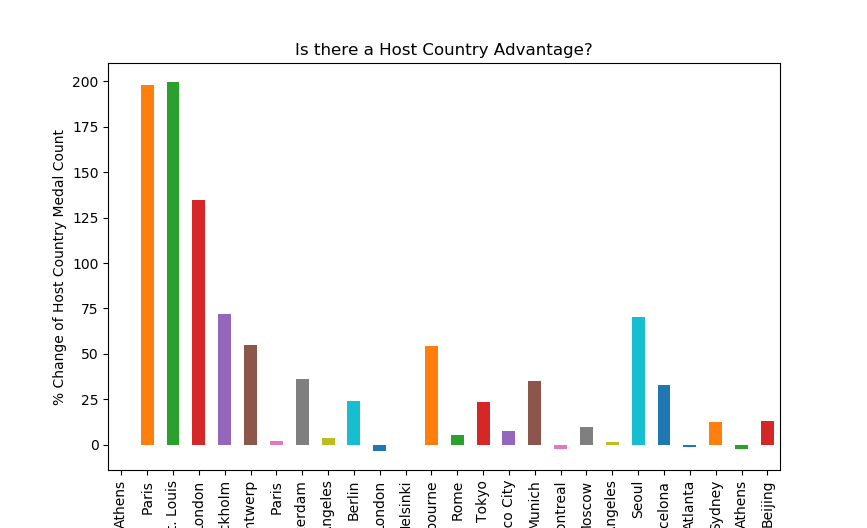

In [15]:
ax = influence['Change'].plot(kind='bar')
ax.set_ylabel("% Change of Host Country Medal Count")
ax.set_title("Is there a Host Country Advantage?")
ax.set_xticklabels(editions['City'])
plt.show()